In [2]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [3]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [4]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [ ]:
# Used to compare to branchpointer (Commented so I don't accidently re-run..)
# c = 0
# with open('../anno/test.tsv', 'w') as fp:
#     ID = 0
#     fp.write('\t'.join(['id', 'chromsome', 'start', 'end', 'strand']) + '\n')
#     for (chrom, three, strand), bp in introns.items():
#         if not bp or chrom == 'chr1':
#             continue
#         if strand == '+':
#             begin, end = str(three - 70), str(three)
#         else:
            
#             begin, end = str(three+1), str(three + 70+1)
#         c += 1
#         fp.write('\t'.join(["{}_{}_{}".format(chrom, three, strand),
#                             chrom, begin, end, strand]) + '\n')
# print c

In [6]:
import pandas
mercer = pandas.ExcelFile('../anno/mercer.Supplemental_TableS1.xlsx')

In [7]:
print mercer.sheet_names
support = mercer.parse('Split-Invert Alignment')
supp = {}
for chrom, pos, strand in zip(support['Chromosome'], support['Start'], support['Strand']):
    if chrom not in supp: supp[chrom] = {}
    supp[chrom][pos] = 1

[u'Match Only', u'Match+Error', u'Match+Insertion', u'Match+Deletion', u'Split-Invert Alignment']


In [8]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, supp):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X += [onehot(seq).reshape(1, L, 4)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            assert int(bp) in supp[chrom]
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
            
        for i in range(L-2):
            if strand == '+':
                coord = three - L + i
            else:
                coord = L - i + three - 1
            if (not _y[i]) and (coord in supp[chrom]):
                _y[i] = -1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, coords, strands = encode(known, supp)

coords = coords[chroms == 'chr1']
strands = strands[chroms == 'chr1']
print np.sum(y == 1)
print np.sum(y == -1)
print X.shape

56808
35610
(37110, 70, 4)


In [9]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 4) (7093, 70, 4) (4306, 70, 4)
(25711, 70) (7093, 70) (4306, 70)


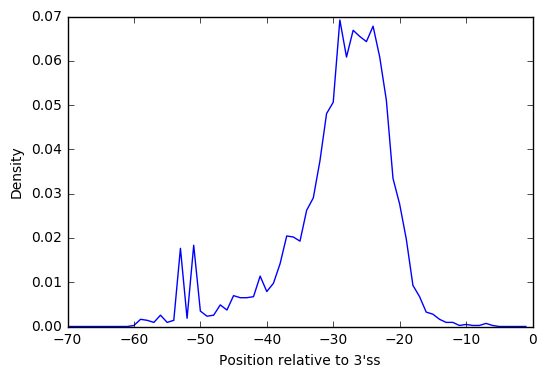

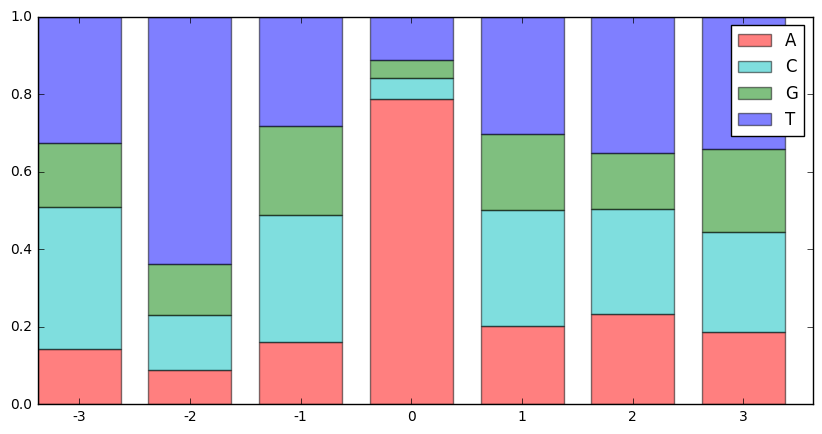

In [10]:
def pwm_logo(pwm, title = '', K = 3):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

def sanity_check(X, y):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        counts[bp] += 1
        total += 1
    dists = counts / float(total)
    plt.plot(range(-70, 0), dists)
    plt.ylabel('Density')
    plt.xlabel("Position relative to 3'ss")
    plt.show()

    K = 3
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    pwm = counts / total
    pwm_logo(pwm)
    
sanity_check(X_test, y_test)

# Load model

In [11]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


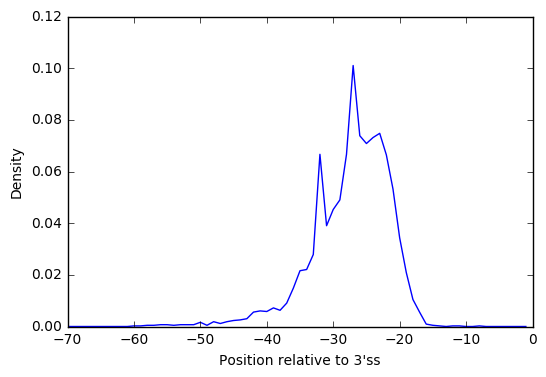

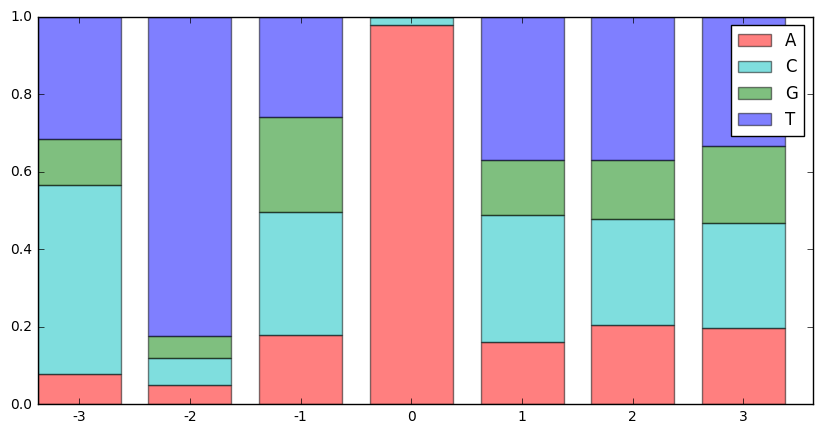

In [12]:
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)
sanity_check(X_test, test_preds)

# Load SVM-BPFinder Predictions
- Cloned current version of SVM-BPFinder from https://bitbucket.org/regulatorygenomicsupf/svm-bpfinder.
- Produced fasta file of length 70 intronic sequences aligned to 3'ss using labranchor/create_fasta.py using hg19 and gencode v19.
- Ran SVM-BPFinder with command "svm-bpfinder/svm_bpfinder.py -i labranchor/gencode.v19.fa -s Hsap -d 15 > svm-bpfinder.tsv"
- Choose best branchpoint using developer recommended AGEZ heuristics. Downloaded from http://regulatorygenomics.upf.edu/Software/SVM_BP/. Command was "perl calculate_best_BP_per_intron.pl < svm_ppfinder_output.txt > best_bp_per_intron.txt".

3797


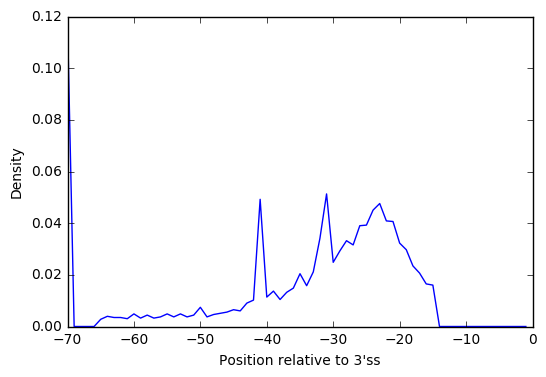

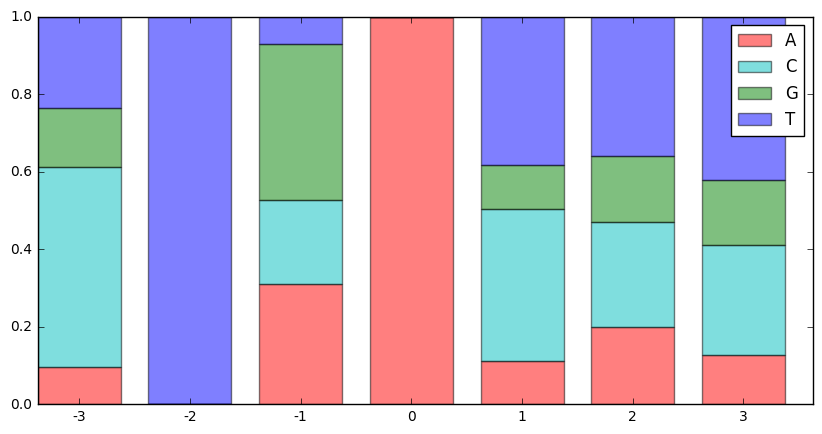

In [13]:
bpfinder = np.zeros(test_preds.shape)
with open('../best_bp_per_intron.txt') as fp:
    for line in fp:
        coord, agez, dist = line.split('\t')[:3]
        chrom, three, strand = coord.split(':')
        dist, three = int(dist), int(three)
        
        if strand == '-': three += 1
        score = float(line.split('\t')[-1])
        if chrom == 'chr1' and three in coords:
            assert 0 < dist < 70
            bpfinder[np.argwhere((coords==three))[0], -dist] = score

# Don't get a branchpoint for all 3'ss because
# ... they screen for branchpoints given a score > 0.
# These appear at distance == -70.
print sum(np.max(bpfinder, axis = 1) > 0)
sanity_check(X_test, bpfinder)

# Load Branchpointer predictions
- See preprocessing/branchpointer.R

112451
4306
(4306, 70)


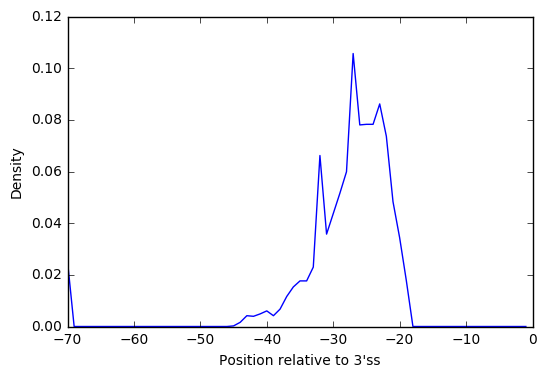

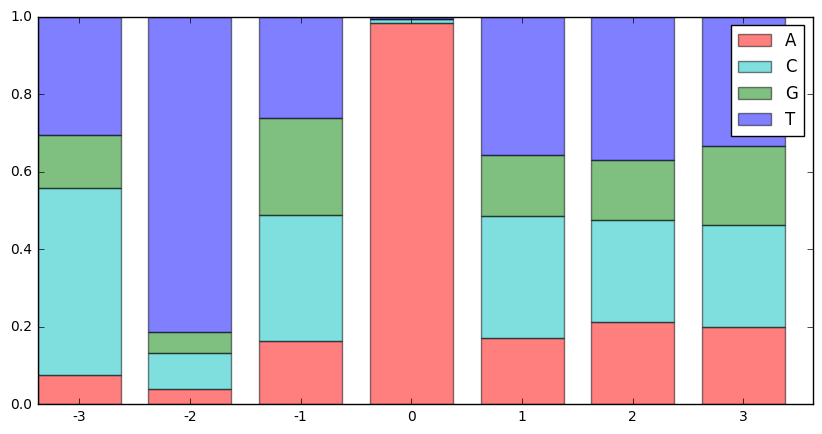

In [14]:
# Load in scores from branchpointer
pos  = []
for line in open('../anno/branchpointer.pos.tsv'):
    pos += map(int, line.strip().split())
scores = []
for line in open('../anno/branchpointer.score.tsv'):
    scores += map(float, line.strip().split())
bptr = {p:score for p, score in zip(pos, scores)}
print len(bptr)
bptr_preds = np.zeros((len(coords), 27))
for i, (three, strand) in enumerate(zip(coords, strands)):
    region = (range(three-44, three - 17)
              if strand == '+' else
              range(three + 45, three + 18, -1))
    #if strand == '+':continue
    for j, pos in enumerate(region):
        bptr_preds[i, j] = bptr[pos] if pos in bptr else 0

# Again, a branchpoint is not predicted for every 3'ss...
bptr_preds = np.hstack([np.zeros((len(coords), 25)), bptr_preds, np.zeros((len(coords), 18))])
print sum(np.max(bpfinder, axis = 1) > -float('inf'))
print bptr_preds.shape
sanity_check(X_test, bptr_preds)

# Model Performance

In [16]:
def shifted_matching(preds, true):
    E, B = 4, 4
    total, match, low_match, low_shifted, shifted = 0, 0, 0, 0, 0
    for p, t in zip(preds, true):
        if not np.sum(t==1): continue
        bp = np.argmax(p)
        if bp in np.array(range(t.shape[0]))[t == 1]:
            match += 1
        elif any(i in np.array(range(t.shape[0]))[t == 1]
                 for i in range(bp-E, bp+B+1)):
            shifted += 1
        ### above is high conf, below is low conf
        if bp in np.array(range(t.shape[0]))[t != 0]:
            low_match += 1
        elif any(i in np.array(range(t.shape[0]))[t != 0]
                 for i in range(bp-E, bp+B+1)):
            low_shifted += 1
            
        total += 1
    heights = [match / float(total),  low_match / float(total),
               (match+shifted) / float(total),
               (low_match+low_shifted) / float(total),
              ]
    return total, heights

print 'All'
print shifted_matching(test_preds, y_test)
print shifted_matching(bptr_preds, y_test)
print shifted_matching(bpfinder, y_test)
print

print '-18 to -45'
print shifted_matching(test_preds[:, -45:-18], y_test[:, -45:-18])
print shifted_matching(bptr_preds[:, -45:-18], y_test[:, -45:-18])
print shifted_matching(bpfinder[:, -45:-18], y_test[:, -45:-18])
print

print 'Only A Branchpoints'
print shifted_matching(test_preds*X_test[:, :, 0], y_test*X_test[:, :, 0])
print shifted_matching(bptr_preds*X_test[:, :, 0], y_test*X_test[:, :, 0])
print shifted_matching(bpfinder * X_test[:, :, 0], y_test*X_test[:, :, 0])
print

All
(4306, [0.7510450534138412, 0.8457965629354389, 0.8797027403622851, 0.9163957268927079])
(4306, [0.6709242916860195, 0.7670692057594055, 0.8197863446353925, 0.8576405016256387])
(4306, [0.47120297259637717, 0.5699024616813748, 0.5833720390153274, 0.6446818392940084])

-18 to -45
(4114, [0.7717549829849295, 0.8648517258142927, 0.9015556635877492, 0.9331550802139037])
(4114, [0.702722411278561, 0.7989790957705396, 0.8541565386485173, 0.8881866796305299])
(4114, [0.4657267865824016, 0.5590666018473505, 0.5753524550315994, 0.6361205639280506])

Only A Branchpoints
(4039, [0.7947511760336717, 0.8672938846249072, 0.8890814558058926, 0.9230007427581084])
(4039, [0.7140381282495667, 0.7865808368408022, 0.8291656350581827, 0.8615994057935132])
(4039, [0.5023520673434019, 0.5855409754889824, 0.5902451101757861, 0.6422381777667739])



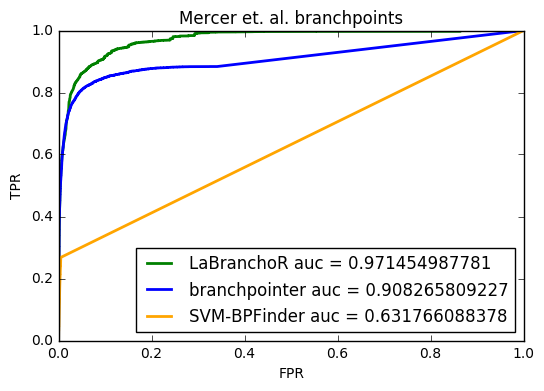

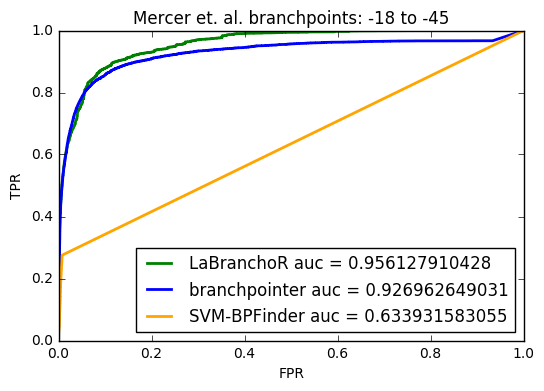

In [40]:
def roc_entry(y, pred, label, color):
    pred[pred == -float('inf')] = -100
    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             pred[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                pred[y != -1])
    plt.plot(fpr, tpr, label = "{} auc = {}".format(label, auc), lw = 2, c = color)
    

def roc(y, preds, labels, colors, title):
    for i in range(len(preds)):
        preds[i] = preds[i][np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    for pred, label, color in zip(preds, labels, colors):
        roc_entry(y, pred, label, color)
    plt.legend(loc = 4)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

roc(y_test, [test_preds, bptr_preds, bpfinder],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Mercer et. al. branchpoints')

roc(y_test[:, -45:-18], [test_preds[:, -45:-18], bptr_preds[:, -45:-18], bpfinder[:, -45:-18]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Mercer et. al. branchpoints: -18 to -45')

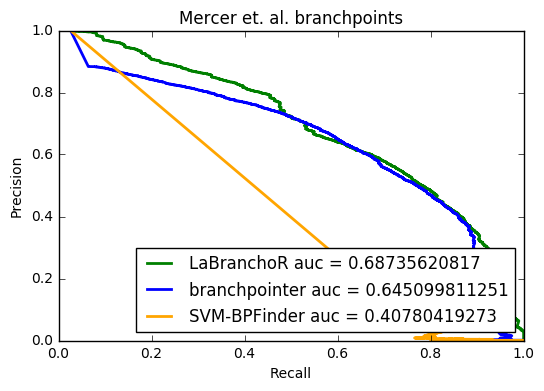

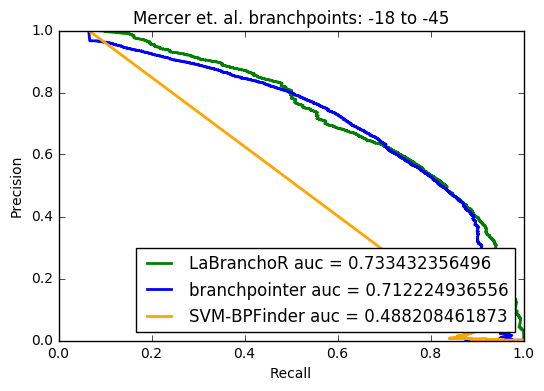

In [39]:
def prc_entry(y, pred, label, color):
    pred[pred == -float('inf')] = -100
    fpr, tpr, thresholds = metrics.precision_recall_curve(y[y != -1],
                                                          pred[y != -1],
                                                          pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                          pred[y != -1])
    plt.plot(fpr, tpr, label = "{} auc = {}".format(label, auc), lw = 2, c = color)
    

def prc(y, preds, labels, colors, title):
    for i in range(len(preds)):
        preds[i] = preds[i][np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    for pred, label, color in zip(preds, labels, colors):
        prc_entry(y, pred, label, color)
    plt.legend(loc = 4)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title(title)
    plt.show()

prc(y_test, [test_preds, bptr_preds, bpfinder],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Mercer et. al. branchpoints')

prc(y_test[:, -45:-18], [test_preds[:, -45:-18], bptr_preds[:, -45:-18], bpfinder[:, -45:-18]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Mercer et. al. branchpoints: -18 to -45')

# Subset to test intersect

In [20]:
# Block Mercer 2016 training set
train_set = {}
with open('../anno/test_train_sites.csv') as fp:
    print fp.readline().strip()
    for line in fp:
        _, group, chrom, strand, pos, conf = line.strip().split(',')
        if conf != 'HC': continue
        if group != 'train': continue
        pos = int(pos)
        if chrom not in train_set: train_set[chrom] = set()
        train_set[chrom].add(pos)

id,testtrain,chromosome,strand,site,set


In [23]:
chrom = 'chr1'
mask = np.array([not any(c in train_set[chrom] for c in range(coord-70, coord+70))
                 for coord, strand in zip(coords, strands)])
print sum(mask)

946


In [42]:
print shifted_matching(test_preds[mask], y_test[mask])
print shifted_matching(bptr_preds[mask], y_test[mask])
print shifted_matching(bpfinder[mask], y_test[mask])

print '-45 to -18'
print shifted_matching(test_preds[mask, -45:-18], y_test[mask, -45:-18])
print shifted_matching(bptr_preds[mask, -45:-18], y_test[mask, -45:-18])
print shifted_matching(bpfinder[mask, -45:-18], y_test[mask, -45:-18])

(946, [0.653276955602537, 0.766384778012685, 0.8002114164904862, 0.854122621564482])
(946, [0.5021141649048626, 0.6088794926004228, 0.6606765327695561, 0.7177589852008457])
(946, [0.43023255813953487, 0.5200845665961945, 0.5528541226215645, 0.6067653276955602])
-45 to -18
(794, [0.7191435768261965, 0.8224181360201511, 0.8727959697732998, 0.9005037783375315])
(794, [0.5982367758186398, 0.7052896725440806, 0.7732997481108312, 0.8123425692695214])
(794, [0.44962216624685136, 0.5327455919395466, 0.5717884130982368, 0.6095717884130982])


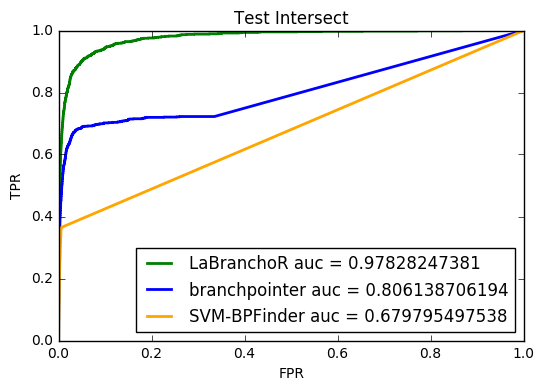

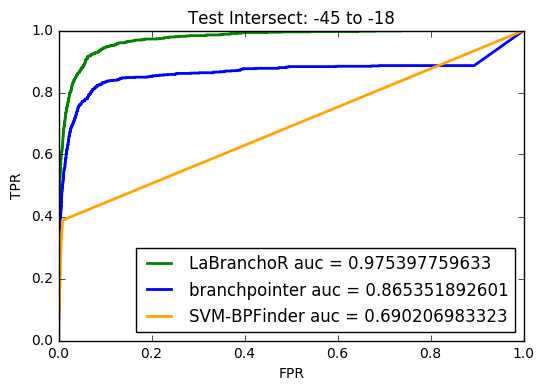

In [44]:
roc(y_test[mask], [test_preds[mask], bptr_preds[mask], bpfinder[mask]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Test Intersect')

roc(y_test[mask, -45:-18], [test_preds[mask, -45:-18], bptr_preds[mask, -45:-18], bpfinder[mask, -45:-18]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Test Intersect: -45 to -18')

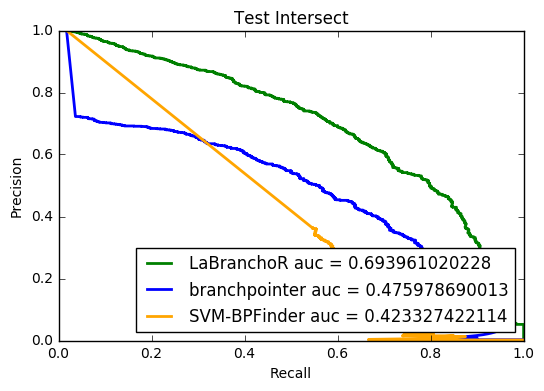

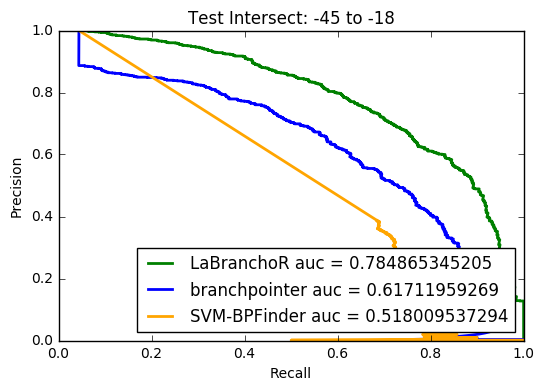

In [45]:
prc(y_test[mask], [test_preds[mask], bptr_preds[mask], bpfinder[mask]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Test Intersect')

prc(y_test[mask, -45:-18], [test_preds[mask, -45:-18], bptr_preds[mask, -45:-18], bpfinder[mask, -45:-18]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Test Intersect: -45 to -18')

# Why does performance degrade on intersection??

Since branchpointer randomly distributed branchpoints, 3'ss with multiple branchpoints often have at least one in the training set. Therefore the intersection of our test sets selects for 3'ss with only one branchpoint.

(946,) (946,)


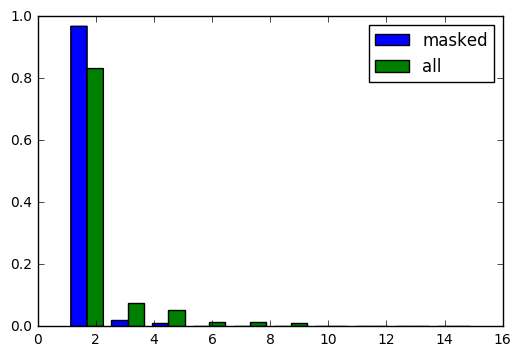

In [27]:
w1 = np.ones_like(np.sum(y_test[mask]==1, axis = 1)) / float(y_test[mask].shape[0])
w2 = np.ones_like(np.sum(y_test==1, axis = 1)) / float(y_test.shape[0])
print w1.shape, np.sum(y_test[mask]==1, axis = 1).shape
plt.hist([np.sum(y_test[mask]==1, axis = 1), np.sum(y_test==1, axis = 1)],
         weights = [w1, w2], label = ['masked', 'all'])
plt.legend()
plt.show()